# Artificial Neural Network
We are using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

First let's import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

In [2]:
#Define a transformation pipeline to convert images
transform = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,))])

In [3]:
#Download the train dataset
trainset = datasets.FashionMNIST('/Users/bagde/Desktop/Vishal/Machine-Learning/Deep Learning/datasets',
                                 download=True, train=True, transform=transform)
#Make a trainloader and define batch_size
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

#Download the test dataset -- Notice: "train=False"
testset = datasets.FashionMNIST('/Users/bagde/Desktop/Vishal/Machine-Learning/Deep Learning/datasets',
                                download=True, train=False, transform=transform)
#Make a testloader and define batch_size
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [4]:
#Function to Display images
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    
    if normalize:
        # Mean
        mean = np.array([0.485, 0.456, 0.406])
        # Standard Deviation
        std = np.array([0.229, 0.224, 0.225])
        # Normalizing the image
        image = std*image + mean
        # Setting lower and upper bound for image values
        image = np.clip(image, a_min=0, a_max=1)
    
    ax.imshow(image)
    return ax

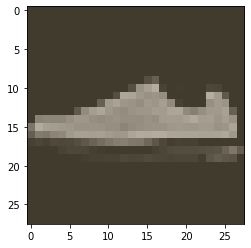

In [5]:
image, label = next(iter(trainloader))
#Plotting the image by calling above defined function
imshow(image[0,:])

## Building the Network
As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. We have included 4 hidden layers. And have used ReLU activations for the hidden layers and log_softmax for the output layer. It's up to you how many layers you add and the size of those layers.

In [6]:
from torch import nn, optim
import torch.nn.functional as F

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(784, 512)        # First hidden layer
        self.fc2 = nn.Linear(512, 256)        # Second hidden layer
        self.fc3 = nn.Linear(256, 128)        # Third hidden layer
        self.fc4 = nn.Linear(128, 64)         # Fourth hidden layer
        self.fc5 = nn.Linear(64, 10)          # Output layer
        
        self.dropout = nn.Dropout(p=0.25)     # Dropout with prob=0.25
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)            # Flattening the images
        
        # Passing images through Network
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        # End of first layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # End of second layer
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        # End of third layer
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        # End of fourth layer
        x = self.dropout(x)
        x = F.log_softmax(self.fc5(x), dim=1)
        # Final layer
        
        return x

## Train the network

We have defined [the criterion](http://pytorch.org/docs/master/nn.html#loss-functions) `nn.CrossEntropyLoss` and can also use  `nn.NLLLoss` and [the optimizer](http://pytorch.org/docs/master/optim.html) as `optim.SGD`,  `optim.Adam` is another popular option.

The training pass is a fairly straightforward process:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights


In [8]:
model = Classifier()
model

Classifier(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [10]:
epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss}")

Training loss: 1464.635948240757
Training loss: 763.7743675112724
Training loss: 624.790531128645
Training loss: 557.0425470769405
Training loss: 516.736355304718


In [11]:
def view_classify(img, ps):
    
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                         'Trouser',
                         'Pullover',
                         'Dress',
                         'Coat',
                         'Sandal',
                         'Shirt',
                         'Sneaker',
                         'Bag',
                         'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

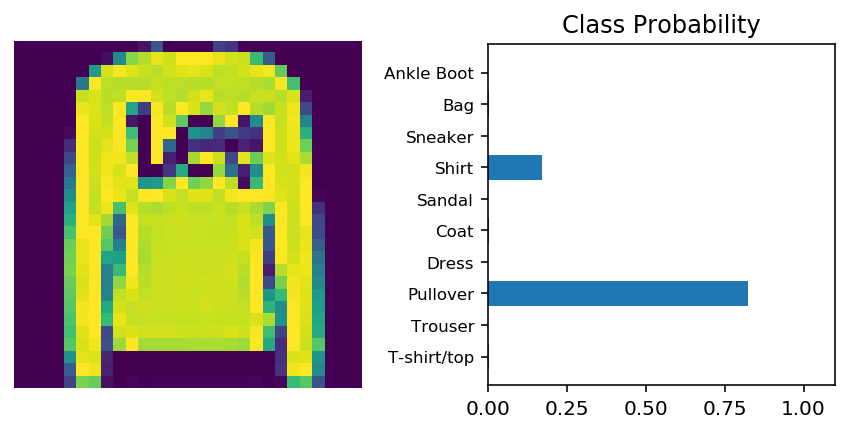

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[1]

ps = torch.exp(model(img))

view_classify(img, ps)